In [1]:
import os
import sys

os.chdir("../..")
sys.path.append("..")

In [2]:
import random
import time
import yaml
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.loader import TrainDataLoader, ValidationDataLoader
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.time_feature import (
    HourOfDay,
    DayOfWeek,
    DayOfMonth,
    DayOfYear,
    MonthOfYear
)
from gluonts.torch.batchify import batchify
from gluonts.transform import (
    AddObservedValuesIndicator,
    AddTimeFeatures,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    ValidationSplitSampler
)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import STL
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm

from src.app.utils import get_prediction_dataloader
from src.models.utils import get_model
from src.utils.data_loading import load_features, load_score, load_test_data, load_train_data
from src.utils.evaluation import score_batch
from src.utils.features import trend_determination, trend_slope, trend_linearity, seasonal_determination, decomps_and_features
from src.utils.transformations import manipulate_trend_component, manipulate_seasonal_determination

/anaconda/envs/whatif/lib/python3.8/site-packages/gluonts/json.py:45: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [3]:
model_name = "nbeats_g"
dataset = "m4_quarterly"

datadir = f"data/{dataset}"
experiment_dir = f"experiments/{dataset}/{model_name}"
generated_datadir = os.path.join(f"/datadrive2/whatif/{dataset}", "generated", "test")
metric = "mase"

In [4]:
with open(os.path.join(experiment_dir, "config.yaml"), "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = get_model(config["model_name"])(**config["model_args"], device=device, path=config["path"])
model.load_state_dict(torch.load(os.path.join(config["path"], "model.pth")))

<All keys matched successfully>

In [5]:
score = load_score(experiment_dir, metric)
score.shape

(24000, 8)

In [6]:
def load_generated_data(feature_prefix, generated_test_datadir, len_test_data):
    features = [0 for _ in range(len_test_data)]
    for f in os.listdir(generated_test_datadir):
        if f.startswith(feature_prefix):
            file_name = f.split(".")[0]  # slice off .npy from file name
            ts_idx = int(file_name[len(feature_prefix):])  # the remaining charachters after prefix is always the time series id
            features[ts_idx] = np.load(os.path.join(generated_test_datadir, f))

    features = np.array(features)  # [len(original_test), num_manipulations, 4]
    return features

### Can we use the already generated data to find out of distribution samples and use those as testing?

In [7]:
feature_prefix = "feat_trend_lin"

gen_features = load_generated_data(feature_prefix, generated_datadir, score.shape[0])
gen_features = gen_features.reshape([-1, 4])  # flatten the two first dimensions
gen_features.shape

(4752000, 4)

In [8]:
train_features = load_features(datadir, train=True)
test_features = load_features(datadir, train=False)
train_features.shape, test_features.shape

((25600, 4), (24000, 4))

In [9]:
scaler = StandardScaler()
norm_train_features = scaler.fit_transform(train_features)
norm_test_features = scaler.transform(test_features)
norm_gen_features = scaler.transform(gen_features)

pca = PCA(n_components=2)
train_pca_data = pca.fit_transform(norm_train_features)
test_pca_data = pca.transform(norm_test_features)
gen_pca_data = pca.transform(norm_gen_features)

(-4.0, 5.0)

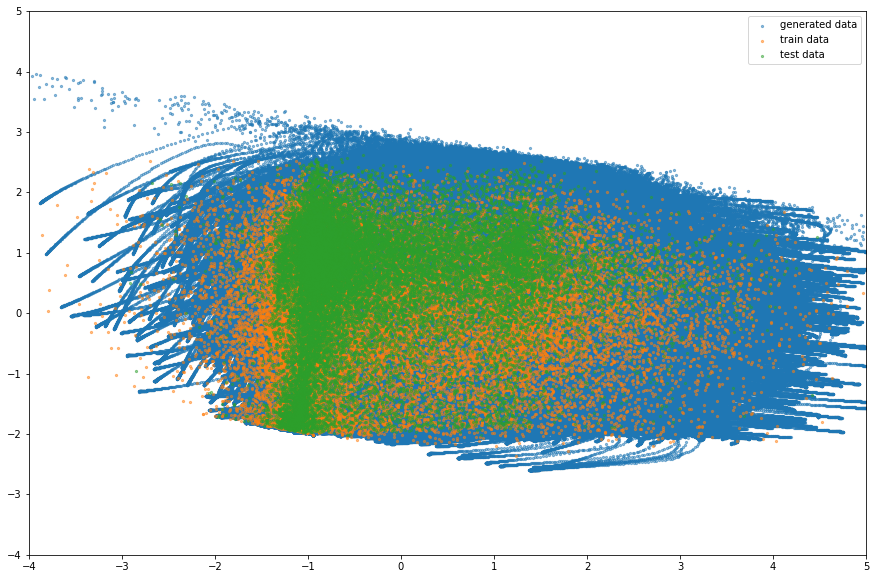

In [10]:
plt.figure(figsize=(15, 10))

plt.scatter(gen_pca_data[:, 0], gen_pca_data[:, 1], label="generated data", s=5, alpha=0.5)
plt.scatter(train_pca_data[:, 0], train_pca_data[:, 1], label="train data", s=5, alpha=0.5)
plt.scatter(test_pca_data[:, 0], test_pca_data[:, 1], label="test data", s=5, alpha=0.5)
plt.legend()
plt.xlim([-4, 5])
plt.ylim([-4, 5])

By selecting the points with the largest reduction in feature value we can create a new distribution in the upper area of the figure, and use that as the new test set

In [11]:
feature_prefix = "feat_trend_lin"

gen_features = load_generated_data(feature_prefix, generated_datadir, score.shape[0])
gen_features = gen_features[:, -1, :].reshape([-1, 4])  # flatten the two first dimensions
gen_features.shape

(24000, 4)

(-4.0, 5.0)

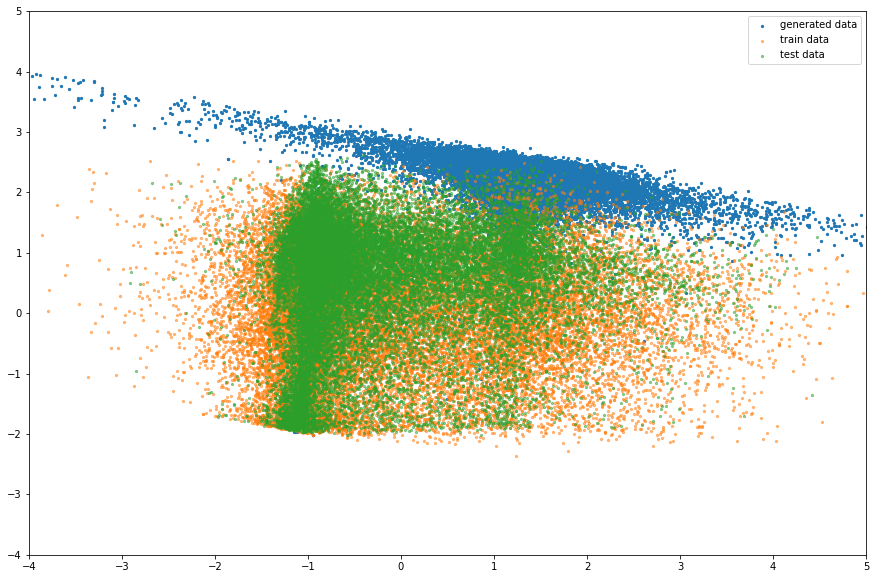

In [12]:
norm_gen_features = scaler.transform(gen_features)
gen_pca_data = pca.transform(norm_gen_features)

plt.figure(figsize=(15, 10))

plt.scatter(gen_pca_data[:, 0], gen_pca_data[:, 1], label="generated data", s=5, alpha=1)
plt.scatter(train_pca_data[:, 0], train_pca_data[:, 1], label="train data", s=5, alpha=0.5)
plt.scatter(test_pca_data[:, 0], test_pca_data[:, 1], label="test data", s=5, alpha=0.5)
plt.legend()
plt.xlim([-4, 5])
plt.ylim([-4, 5])

In [13]:
def sample_and_plot_from_dataloader(dataloader, sp, scaler, pca, train_pca_data, test_pca_data, num_samples=20000, lim=True):
    sampled_series = []
    for batch in dataloader:
        data = torch.cat([batch["past_target"], batch["future_target"]], dim=-1)
        for ts in data:
            sampled_series.append(ts)

        if len(sampled_series) > num_samples:
            break

    _, sampled_features = decomps_and_features(sampled_series, sp)
    sampled_scaled_features = scaler.transform(sampled_features)
    sampled_pca_data = pca.transform(sampled_scaled_features)

    plt.figure(figsize=(15, 10))
    
    if train_pca_data is not None:
        plt.scatter(train_pca_data[:, 0], train_pca_data[:, 1], label="train data", s=5, alpha=.1)
    if test_pca_data is not None:
        plt.scatter(test_pca_data[:, 0], test_pca_data[:, 1], label="test data", s=5, alpha=.1)
    
    plt.scatter(sampled_pca_data[:, 0], sampled_pca_data[:, 1], label="transformed train data", s=5, alpha=.1, color="r")
    plt.legend()
    
    if lim:
        plt.xlim([-3, 8])
        plt.ylim([-4, 9])
    
    return sampled_series

In [14]:
def create_train_dataloader(dataset, context_length, prediction_length, batch_size, num_batches_per_epoch):
    transformation = Chain([
        AddObservedValuesIndicator(
            target_field=FieldName.TARGET,
            output_field=FieldName.OBSERVED_VALUES,
        ),
        AddTimeFeatures(
            start_field=FieldName.START,
            target_field=FieldName.TARGET,
            output_field=FieldName.FEAT_TIME,
            pred_length=prediction_length,
            time_features=[HourOfDay(), DayOfWeek(), DayOfMonth(), DayOfYear(), MonthOfYear()]
        ),
        InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            instance_sampler=ExpectedNumInstanceSampler(num_instances=1, min_past=context_length,
                                                        min_future=prediction_length),
            past_length=context_length,
            future_length=prediction_length,
            time_series_fields=[FieldName.FEAT_TIME, FieldName.OBSERVED_VALUES]
        )
    ])
    dataloader = TrainDataLoader(
        dataset,
        batch_size=batch_size,
        stack_fn=batchify,
        transform=transformation,
        num_batches_per_epoch=num_batches_per_epoch,
        num_workers=1
    )
    return dataloader

In [15]:
def create_validation_dataloader(dataset, context_length, prediction_length, batch_size, num_batches_per_epoch):
    transformation = Chain([
        AddObservedValuesIndicator(
            target_field=FieldName.TARGET,
            output_field=FieldName.OBSERVED_VALUES,
        ),
        AddTimeFeatures(
            start_field=FieldName.START,
            target_field=FieldName.TARGET,
            output_field=FieldName.FEAT_TIME,
            pred_length=prediction_length,
            time_features=[HourOfDay(), DayOfWeek(), DayOfMonth(), DayOfYear(), MonthOfYear()]
        ),
        InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            instance_sampler=ValidationSplitSampler(min_future=prediction_length),
            past_length=context_length,
            future_length=prediction_length,
            time_series_fields=[FieldName.FEAT_TIME, FieldName.OBSERVED_VALUES]
        )
    ])
    dataloader = ValidationDataLoader(
        dataset,
        batch_size=batch_size,
        stack_fn=batchify,
        transform=transformation,
        num_workers=1
    )
    return dataloader

In [16]:
def get_train_and_val_data(dataset, num_validation_windows, context_length, prediction_length):
    train_data = ListDataset(list(iter(dataset.train)), freq=dataset.metadata.freq)
    validation_data = []
    for i in range(num_validation_windows):
        for ts in train_data.list_data:
            # only add time series long enough that we can remove one horizon and still have context_length +
            # prediction_length values left
            if len(ts["target"]) <= context_length + prediction_length * (i + 2):
                continue

            val_ts = deepcopy(ts)
            val_ts["target"] = val_ts["target"][:-prediction_length * i if i > 0 else None]
            val_ts["target"] = val_ts["target"][-(context_length + prediction_length):]
            validation_data.append(val_ts)

            # slice off the validation data from the training data
            if i == num_validation_windows - 1:
                ts["target"] = ts["target"][:-prediction_length * (i + 1)]
    
    return train_data, ListDataset(validation_data, freq=dataset.metadata.freq)

In [17]:
def add_to_dataset(original_data, generated_data):
    for i, ts in enumerate(generated_data):
        entry = {"start": ts.index[0], "target": ts.values, "feat_static_cat": np.array([i]), "item_id": i}
        original_data.list_data.append(entry)
    
    return original_data

In [18]:
def change_trend_lin(data, sp, h):
    generated = []
    for i, ts in tqdm(enumerate(data)):
        index = pd.date_range(start=ts["start"], freq=ts["start"].freq, periods=len(ts["target"]))
        ts = pd.Series(data=ts["target"], index=index)
        decomp = STL(ts, period=2).fit()
        
        new_trend = manipulate_trend_component(decomp.trend, f=1, g=1, h=h, m=0)
        new_ts = new_trend + decomp.seasonal + decomp.resid
        generated.append(new_ts)
    
    return generated

In [19]:
dataset = get_dataset(config["dataset"])
train_data, validation_data = get_train_and_val_data(dataset, 1, config["trainer_args"]["context_length"],
                                                     config["trainer_args"]["prediction_length"])

In [20]:
generated_train = change_trend_lin(train_data, config["sp"], h=0.01)
expanded_train = add_to_dataset(train_data, generated_train)

24000it [02:00, 199.85it/s]


In [21]:
generated_val = change_trend_lin(validation_data, config["sp"], h=0.01)
expanded_val = add_to_dataset(validation_data, generated_val)

23140it [01:05, 351.79it/s]


In [22]:
train_dataloader = create_train_dataloader(expanded_train, config["trainer_args"]["context_length"], config["trainer_args"]["prediction_length"],
                                           config["trainer_args"]["batch_size"], config["trainer_args"]["num_batches_per_epoch"] * 2)

validation_dataloader = create_validation_dataloader(expanded_val, config["trainer_args"]["context_length"], config["trainer_args"]["prediction_length"],
                                                     config["trainer_args"]["batch_size"], config["trainer_args"]["num_batches_per_epoch"])

51200it [01:21, 624.76it/s]


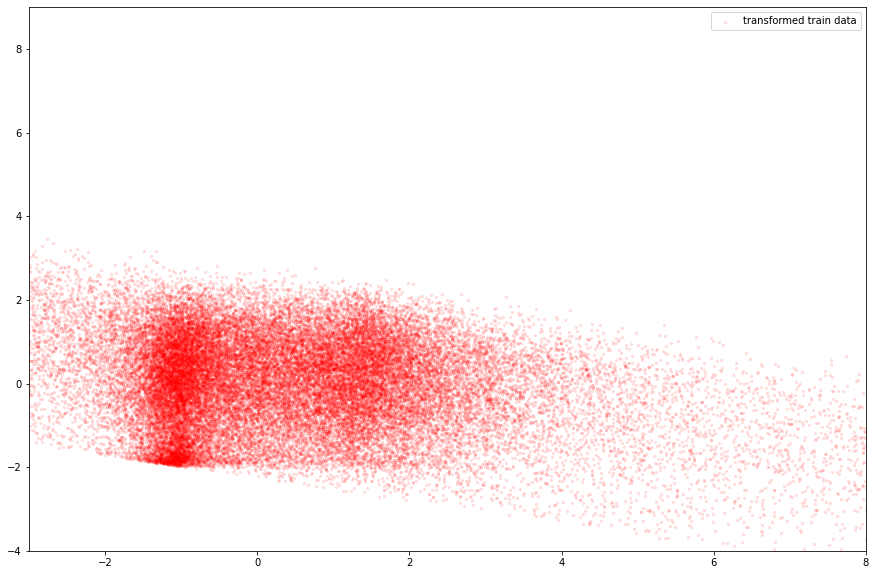

In [23]:
_ = sample_and_plot_from_dataloader(train_dataloader, config["sp"], scaler, pca, None, None, num_samples=60000)

46280it [01:12, 635.52it/s]


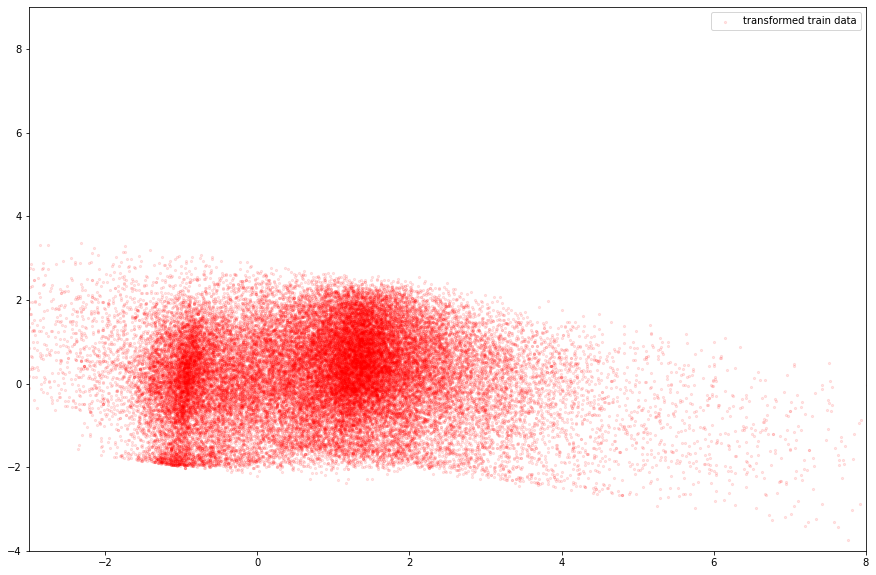

In [24]:
_ = sample_and_plot_from_dataloader(validation_dataloader, config["sp"], scaler, pca, None, None, num_samples=len(expanded_val))